In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch_geometric.utils import degree

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [149]:
def get_degree(dataset):
    data = load_dataset(dataset, device='cpu')
    idx = data.edge_index[0]
    return degree(idx, num_nodes=data.num_nodes).int().numpy()


def load_results(tasks, datasets, methods, eps_list):
    df_total = pd.DataFrame()
    for task in tasks:
        for dataset in datasets:
            for method in methods:
                try:
                    df = pd.read_pickle(f'results/{task}_{dataset}_{method}.pkl')
                    df = df[df['eps'].isin(eps_list)]
                    df_total = df_total.append(df, ignore_index=True)
                except FileNotFoundError:
                    pass
    
    return df_total


def load_error_results(datasets, methods, eps_list, max_deg_quantile=None):
    df_total = pd.DataFrame()
    for dataset in datasets:
        if max_deg_quantile is not None:
            max_deg = np.quantile(get_degree(dataset), max_deg_quantile)
            
        for method in methods:
            df = load_results(tasks=['error'], datasets=[dataset], methods=[method], eps_list=eps_list)

            if len(df) > 0:
                df = df.explode('test_result')
                df[['error','degree']] = pd.DataFrame(df['test_result'].tolist(),index=df.index)

                if max_deg_quantile is not None:
                    df = df[df['degree'] <= max_deg]

                df_total = df_total.append(df, ignore_index=True)
            
    return df_total


def load_test_results(tasks, datasets, methods, eps_list):
    append_raw = False
    if 'raw' in methods:
        methods = methods.copy()
        methods.remove('raw')
        append_raw = True
        
    df = load_results(tasks=tasks, datasets=datasets, methods=methods, eps_list=eps_list)
    
    if append_raw:
        df_raw = load_results(tasks=tasks, datasets=datasets, methods=['raw'], eps_list=[0])
        df_raw['eps'] = [eps_list] * len(df_raw)
        df_raw = df_raw.explode('eps')
        df = df.append(df_raw, ignore_index=True)
        
    return df


# only to export plot data to file
def export_to_file(data, x, y, hue, col, task, expr):
    data = data.groupby([col, hue, x]).agg({y: ['mean', lambda x: np.std(x)]}).reset_index()
    data.columns = [col, hue, x, 'mean', 'std']
    data.groupby([col, hue]).apply(
        lambda df: df[[x, 'mean', 'std']].to_csv(
            f"figures/{task}-{df[col].unique().item()}-{df[hue].unique().item()}-{expr}.txt", 
            index=None, 
            sep=' '
        )
    )

# Estimation Error

### Effect of epsilon

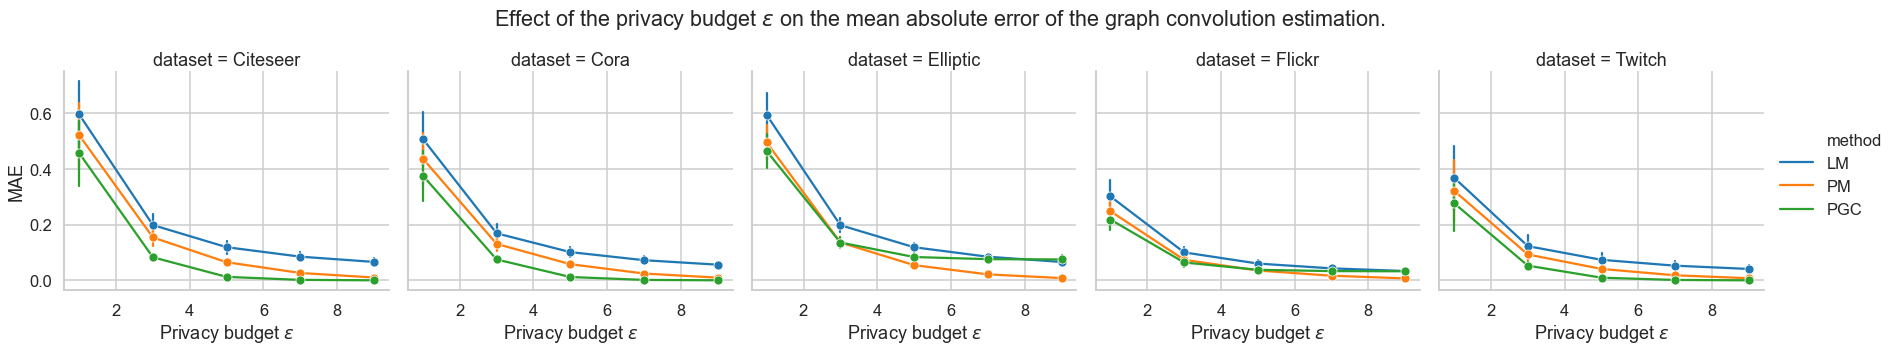

In [150]:
df = load_error_results(
    datasets=['citeseer', 'cora', 'elliptic', 'flickr', 'twitch'], 
    methods=['lm', 'pm', 'pgc'], 
    eps_list=[1, 3, 5, 7, 9]
)

df['dataset'] = df['dataset'].str.title()
df['method'] = df['method'].str.upper()

ax = sns.relplot(
    kind='line', data=df, x='eps', y='error', hue='method', col='dataset', ci='sd', err_style='bars', marker='o', 
    facet_kws=dict(sharex=False, sharey=True), col_wrap=5,
)
ax.set_ylabels('MAE')
ax.set_xlabels('Privacy budget $\epsilon$')
ax.fig.suptitle('Effect of the privacy budget $\epsilon$ on the mean absolute error of the graph convolution estimation.')
ax.fig.subplots_adjust(top=.8)

# export_to_file(data=df, x='eps', y='error', hue='method', col='dataset', task='error', expr='eps')

### Effect of node degree

Extracting datasets/Elliptic/raw/elliptic_bitcoin_dataset/vhmlkw9b24sxsfwh5in9jypmx2azgaac.zip


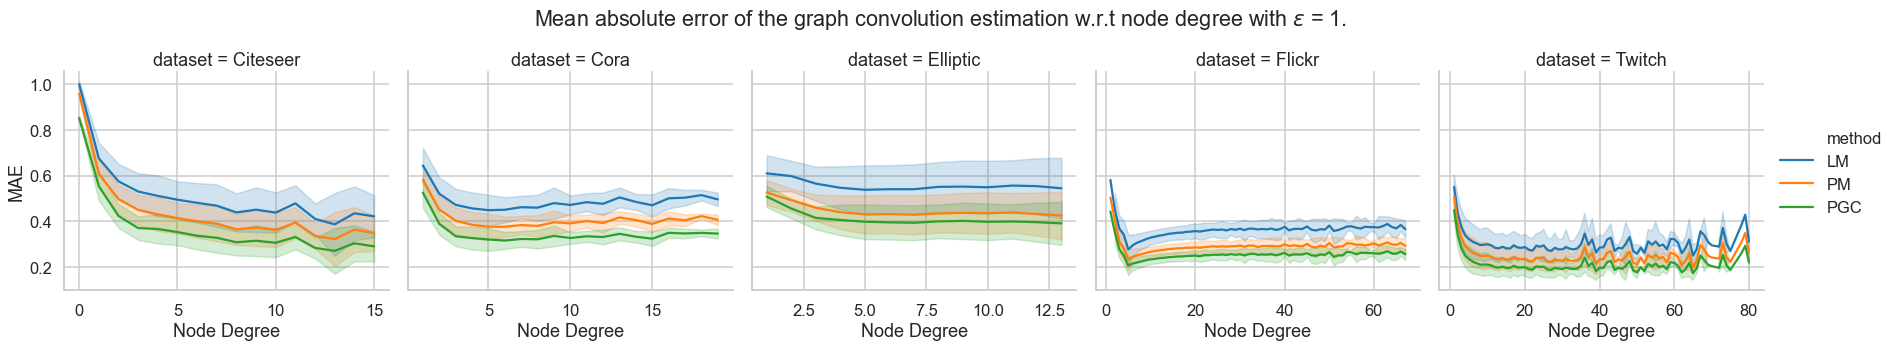

In [151]:
df = load_error_results(
    datasets=['citeseer', 'cora', 'elliptic', 'flickr', 'twitch'], 
    methods=['lm', 'pm', 'pgc'], 
    eps_list=[1], 
    max_deg_quantile=0.99
)

df['dataset'] = df['dataset'].str.title()
df['method'] = df['method'].str.upper()

ax = sns.relplot(
    kind='line', data=df, x='degree', y='error', hue='method', col='dataset', ci='sd', 
    facet_kws=dict(sharex=False, sharey=True), col_wrap=5,
)
ax.set_ylabels('MAE')
ax.set_xlabels('Node Degree')
ax.fig.suptitle('Mean absolute error of the graph convolution estimation w.r.t node degree with $\epsilon$ = 1.')
ax.fig.subplots_adjust(top=.8)

# export_to_file(data=df, x='degree', y='error', hue='method', col='dataset', task='error', expr='deg')

# Predictive Performance

In [110]:
tasks = ['node', 'link']
datasets = ['citeseer', 'cora', 'elliptic', 'flickr', 'twitch']
methods = ['lm', 'pm', 'pgc', 'raw']
eps_list = [1, 5, 9]

df = load_test_results(tasks=tasks, datasets=datasets, methods=methods, eps_list=eps_list)
df = df.groupby(['dataset', 'task', 'method', 'eps']).agg({'test_result': ['mean', lambda x: np.std(x)]}).reset_index()
df = df.replace(tasks, ['Node Classification', 'Link Prediction'])
df = df.replace(methods, ['1-LM', '2-PM', '3-PGC', '4-Raw'])
df['dataset'] = df['dataset'].str.title()
df.columns = ['Dataset', 'Task', 'Method', '$\epsilon$', 'mean', 'std']
df['result'] = df[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean']*100, row['std']*100), axis=1)
df = df.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$', 'Task'])
df = df.unstack().unstack()
df = df.rename(index={'1-LM': 'LM', '2-PM': 'PM', '3-PGC': 'PGC', '4-Raw': 'Raw'})
columns = [('result', task, eps) for task in ('Node Classification', 'Link Prediction') for eps in eps_list]
columns = pd.MultiIndex.from_tuples(columns, names=[None, 'Task', '$\epsilon$'])
df = df[columns]

df

result                                                                                
Task            Node Classification                                 Link Prediction                                
$\epsilon$                      1.0             5.0             9.0             1.0             5.0             9.0
Dataset  Method                                                                                                    
Citeseer LM          37.1 $\pm$ 1.2  57.6 $\pm$ 1.5  67.8 $\pm$ 1.6  70.0 $\pm$ 3.1  84.4 $\pm$ 1.0  88.6 $\pm$ 0.6
         PM          37.9 $\pm$ 1.1  65.7 $\pm$ 0.5  71.4 $\pm$ 0.5  72.2 $\pm$ 2.3  87.7 $\pm$ 0.9  92.4 $\pm$ 0.2
         PGC         38.3 $\pm$ 0.9  71.2 $\pm$ 0.8  71.5 $\pm$ 0.5  74.7 $\pm$ 3.1  91.9 $\pm$ 0.6  93.3 $\pm$ 0.4
         Raw         71.6 $\pm$ 0.4  71.6 $\pm$ 0.4  71.6 $\pm$ 0.4  93.4 $\pm$ 0.4  93.4 $\pm$ 0.4  93.4 $\pm$ 0.4
Cora     LM          51.8 $\pm$ 1.3  73.6 $\pm$ 1.3  78.4 $\pm$ 0.7  82.7 $\pm$ 3.3  90.1 $\pm$ 0.7  92.0 $\pm$ 0.5
         PM          53.4 $\pm$ 1.7  77.8 $\pm$ 0.6  80.7 $\pm$ 0.4  85.7 $\pm$ 1.9  91.6 $\pm$ 0.4  92.8 $\pm$ 0.5
         PGC         54.7 $\pm$ 1.1  80.1 $\pm$ 0.4  81.1 $\pm$ 0.4  85.6 $\pm$ 1.0  92.8 $\pm$ 0.4  93.1 $\pm$ 0.3
         Raw         81.3 $\pm$ 0.3  81.3 $\pm$ 0.3  81.3 $\pm$ 0.3  92.9 $\pm$ 0.2  92.9 $\pm$ 0.2  92.9 $\pm$ 0.2
Elliptic LM          90.4 $\pm$ 0.1  90.8 $\pm$ 0.3  92.4 $\pm$ 0.4  56.4 $\pm$ 0.5  74.9 $\pm$ 0.7  80.1 $\pm$ 0.5
         PM          90.3 $\pm$ 0.1  92.3 $\pm$ 0.5  93.9 $\pm$ 0.6  59.4 $\pm$ 0.6  80.2 $\pm$ 0.5  85.2 $\pm$ 0.4
         PGC         90.3 $\pm$ 0.1  91.6 $\pm$ 0.5  91.9 $\pm$ 0.6  59.9 $\pm$ 0.6  75.6 $\pm$ 0.3  76.2 $\pm$ 0.4
         Raw         94.9 $\pm$ 0.4  94.9 $\pm$ 0.4  94.9 $\pm$ 0.4  85.8 $\pm$ 0.8  85.8 $\pm$ 0.8  85.8 $\pm$ 0.8
Flickr   LM          45.3 $\pm$ 0.5  48.9 $\pm$ 0.5  50.0 $\pm$ 0.4  67.3 $\pm$ 0.4  72.6 $\pm$ 0.6  76.3 $\pm$ 1.0
         PM          46.0 $\pm$ 0.4  49.8 $\pm$ 0.2  51.4 $\pm$ 0.2  67.4 $\pm$ 0.3  76.0 $\pm$ 0.7  76.2 $\pm$ 1.0
         PGC         45.6 $\pm$ 0.5  49.1 $\pm$ 0.4  49.5 $\pm$ 0.2  67.5 $\pm$ 0.3  75.4 $\pm$ 0.9  75.9 $\pm$ 0.7
         Raw         52.2 $\pm$ 0.2  52.2 $\pm$ 0.2  52.2 $\pm$ 0.2  77.2 $\pm$ 0.8  77.2 $\pm$ 0.8  77.2 $\pm$ 0.8
Twitch   LM          57.4 $\pm$ 0.5  59.6 $\pm$ 0.6  59.6 $\pm$ 0.4  80.8 $\pm$ 1.2  83.7 $\pm$ 0.3  85.2 $\pm$ 0.4
         PM          58.3 $\pm$ 0.8  60.0 $\pm$ 0.8  61.0 $\pm$ 0.5  81.2 $\pm$ 0.7  84.9 $\pm$ 0.3  86.0 $\pm$ 0.4
         PGC         57.9 $\pm$ 1.1  61.0 $\pm$ 0.8  62.6 $\pm$ 0.4  81.7 $\pm$ 0.3  85.9 $\pm$ 0.4  86.8 $\pm$ 0.3
         Raw         62.6 $\pm$ 0.3  62.6 $\pm$ 0.3  62.6 $\pm$ 0.3  86.5 $\pm$ 0.5  86.5 $\pm$ 0.5  86.5 $\pm$ 0.5

### Latex Output

In [148]:
df_max = df.applymap(
    lambda x: float(x[:4])                   # considering the mean part
).groupby('Dataset').apply(
    lambda x: x - x.iloc[-1]                 # calculate the diff between Raw method and others
).groupby('Dataset').apply(
    lambda x : x == x.iloc[-2::-1].max()     # pick the results which are closer to Raw
)

df_max.loc[(slice(None), 'Raw'), :] = False  # prevent making Raw results bold

# make near optimal results bold
df_bold = df.copy()
df_bold[df_max] = df_bold[df_max].applymap(lambda x: '\\textbf{' + str(x) + '}')

# print latex code
df_bold.insert(3, '', '')
latex = df_bold.to_latex(escape=False)
for line in latex.splitlines():
    if line.find('Raw') == -1:
        print(line)
    else:
        print('\\cmidrule{2-9}')
        print(line)
        print('\\midrule')

\begin{tabular}{lllllllll}
\toprule
       & {} & \multicolumn{4}{l}{result} & \multicolumn{3}{l}{result} \\
       & Task & \multicolumn{4}{l}{Node Classification} & \multicolumn{3}{l}{Link Prediction} \\
       & $\epsilon$ &                      1.0 &                      5.0 & \multicolumn{2}{l}{9.0} &                      1.0 &                      5.0 &                      9.0 \\
Dataset & Method &                          &                          &                          &   &                          &                          &                          \\
\midrule
Citeseer & LM &           37.1 $\pm$ 1.2 &           57.6 $\pm$ 1.5 &           67.8 $\pm$ 1.6 &   &           70.0 $\pm$ 3.1 &           84.4 $\pm$ 1.0 &           88.6 $\pm$ 0.6 \\
       & PM &           37.9 $\pm$ 1.1 &           65.7 $\pm$ 0.5 &           71.4 $\pm$ 0.5 &   &           72.2 $\pm$ 2.3 &           87.7 $\pm$ 0.9 &           92.4 $\pm$ 0.2 \\
       & PGC &  \textbf{38.3 $\pm$ 0.9} &  \textbf{